In [25]:
import torch
import dataset.create_dataset as D
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau


import warnings

# Ignore DeprecationWarnings
warnings.filterwarnings("ignore")


In [26]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

LEARNING_RATE = 1e-2
img_H, img_W = 128, 224

num_epochs = 5
batch_size = D.BATCH_SIZE


In [27]:

def loss_fc(outputs, targets):
    out1, out2, out3 = outputs
    t1, t2, t3 = targets

    loss1 = nn.CrossEntropyLoss()(out1, t1)
    loss2 = nn.CrossEntropyLoss()(out2, t2)
    loss3 = nn.CrossEntropyLoss()(out3, t3)

    return (loss1 + loss2 + loss3)/3

In [28]:
from models.resnet34 import resnet34

In [29]:
model = resnet34().to(device)

train_loader,_, val_loader = D.dividing_datasets(img_H, img_W)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True, threshold=1e-4, cooldown=3)

if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

Dataset 'train' initialized. Loaded 173523 images. Skipped 2420 missing files.
Dataset 'test' initialized. Loaded 21702 images. Skipped 302 missing files.
Dataset 'val' initialized. Loaded 22311 images. Skipped 311 missing files.


In [30]:
train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    successful_batches = 0

    for _, data in enumerate(train_loader):
        try:
            # Your existing training code here
            image = data["image"]
            grapheme_root = data["grapheme_root"]
            vowel_diacritic = data["vowel_diacritic"]
            consonant_diacritic = data["consonant_diacritic"]

            image = image.to(device, dtype=torch.float)
            grapheme_root = grapheme_root.to(device, dtype=torch.long)
            vowel_diacritic = vowel_diacritic.to(device, dtype=torch.long)
            consonant_diacritic = consonant_diacritic.to(device, dtype=torch.long)

            targets = (grapheme_root, vowel_diacritic, consonant_diacritic)
            optimizer.zero_grad()
            outputs = model(image)
            total_loss = loss_fc(outputs, targets)
            total_loss.backward()
            optimizer.step()
            running_loss += total_loss.item()
            successful_batches += 1
            
        except Exception as e:
            # This handles the FileNotFoundError coming from the DataLoader worker
            print(f"Skipping batch due to error: {e}")
            continue

    # Rest of your code remains the same...
    average_loss = running_loss / successful_batches if successful_batches > 0 else float('inf')
    
    # Validation (with similar error handling)
    model.eval()
    val_loss = 0.0
    successful_val_batches = 0
    
    with torch.no_grad():
        for _, data in enumerate(val_loader):
            try:
                # Your existing validation code here
                image = data["image"]
                grapheme_root = data["grapheme_root"]
                vowel_diacritic = data["vowel_diacritic"]
                consonant_diacritic = data["consonant_diacritic"]

                image = image.to(device, dtype=torch.float)
                grapheme_root = grapheme_root.to(device, dtype=torch.long)
                vowel_diacritic = vowel_diacritic.to(device, dtype=torch.long)
                consonant_diacritic = consonant_diacritic.to(device, dtype=torch.long)

                targets = (grapheme_root, vowel_diacritic, consonant_diacritic)
                outputs = model(image)
                loss = loss_fc(outputs, targets)
                val_loss += loss.item()
                successful_val_batches += 1
            except Exception as e:
                print(f"Skipping validation batch due to error: {e}")
                continue
    
    val_loss = val_loss / successful_val_batches if successful_val_batches > 0 else float('inf')
    
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {average_loss:.4f}')
    print(f'Validation Loss: {val_loss:.4f}')
    
    train_losses.append(average_loss)
    valid_losses.append(val_loss)
    
    if successful_val_batches > 0:
        scheduler.step(val_loss)

print('Training complete')
torch.save(model.state_dict(), 'char_level_trained_model_128x224_2.pth')

Epoch [1/5], Train Loss: 0.8366
Validation Loss: 0.2926
Epoch [2/5], Train Loss: 0.2218
Validation Loss: 0.2212
Epoch [3/5], Train Loss: 0.1609
Validation Loss: 0.1689
Epoch [4/5], Train Loss: 0.1250
Validation Loss: 0.1680
Epoch [5/5], Train Loss: 0.0979
Validation Loss: 0.1737
Training complete


In [31]:
extra = 1

In [32]:
model.train()
running_loss = 0.0

for _, data in enumerate(train_loader):
    image = data["image"]
    grapheme_root = data["grapheme_root"]
    vowel_diacritic = data["vowel_diacritic"]
    consonant_diacritic = data["consonant_diacritic"]

    image = image.to(device, dtype=torch.float)
    grapheme_root = grapheme_root.to(device, dtype=torch.long)
    vowel_diacritic = vowel_diacritic.to(device, dtype=torch.long)
    consonant_diacritic = consonant_diacritic.to(device, dtype=torch.long)

    targets = (grapheme_root, vowel_diacritic, consonant_diacritic)

    optimizer.zero_grad()

    outputs = model(image)

    total_loss = loss_fc(outputs, targets)

    # Backward and optimize
    total_loss.backward()
    optimizer.step()

    # Update running loss
    running_loss += total_loss.item()

# Calculate average training loss for the epoch
average_loss = running_loss / len(train_loader)


#writes.flush()


# Validation
model.eval()
val_loss = 0.0

with torch.no_grad():
    for _, data in enumerate(val_loader):
        image = data["image"]
        grapheme_root = data["grapheme_root"]
        vowel_diacritic = data["vowel_diacritic"]
        consonant_diacritic = data["consonant_diacritic"]

        image = image.to(device, dtype= torch.float)
        grapheme_root = grapheme_root.to(device, dtype= torch.long)
        vowel_diacritic = vowel_diacritic.to(device, dtype= torch.long)
        consonant_diacritic = consonant_diacritic.to(device, dtype= torch.long)

        targets = (grapheme_root, vowel_diacritic, consonant_diacritic)

        outputs = model(image)

        loss = loss_fc(outputs, targets)
        val_loss += loss.item()
    
print(f'Epoch [{epoch + 1 + extra}],\nTrain Loss: {average_loss}')
val_loss /= len(val_loader)
print(f'Validation Loss: {val_loss}')
train_losses.append(average_loss)
valid_losses.append(val_loss)
scheduler.step(val_loss)

extra += 1

Epoch [6],
Train Loss: 0.07779005283811254
Validation Loss: 0.15984229891851842


In [33]:
torch.save(model.state_dict(), 'char_level_trained_model_128x224_2.pth')

In [34]:
import matplotlib.pyplot as plt

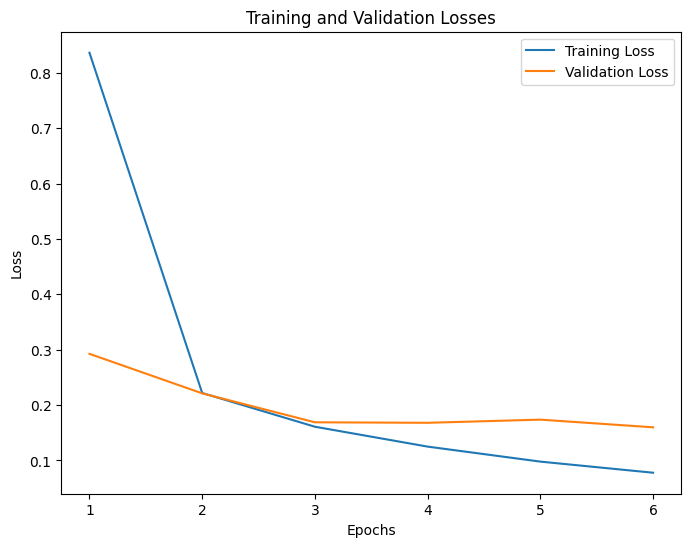

In [35]:
# Dynamically set epochs to the actual number of losses recorded (which is 6)
epochs_run = range(1, len(train_losses) + 1) 

plt.figure(figsize=(8, 6))
# Plot all recorded losses, using the new, correct epochs_run list
plt.plot(epochs_run, train_losses, label='Training Loss')
plt.plot(epochs_run, valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

# --- End Fix ---

In [40]:
from models.resnet34 import resnet34
import torch
import dataset.create_dataset as D
from mapping import grapheme_root_components,vowel_diacritic_components,consonant_diacritic_components

_, test_loader, _ = D.dividing_datasets(128, 224)
device  = 'cuda' if torch.cuda.is_available() else 'cpu'

# Define the same model architecture as in the training script
model = resnet34().to(device)

# Load the trained weights
model.load_state_dict(torch.load('char_level_trained_model_128x224_shoroborno_again.pth'))

Dataset 'train' initialized. Loaded 173523 images. Skipped 2420 missing files.
Dataset 'test' initialized. Loaded 21702 images. Skipped 302 missing files.
Dataset 'val' initialized. Loaded 22311 images. Skipped 311 missing files.


<All keys matched successfully>

In [41]:
def show_char(grapheme_root, vowel_diacritic, consonant_diacritic):
    correct_char = []
    
    # Debug: Print the indices
    print(f"Indices - Grapheme: {grapheme_root}, Vowel: {vowel_diacritic}, Consonant: {consonant_diacritic}")
    print(f"Mapping sizes - Grapheme: {len(grapheme_root_components)}, Vowel: {len(vowel_diacritic_components)}, Consonant: {len(consonant_diacritic_components)}")
    
    # Check bounds and handle out-of-range indices
    if grapheme_root >= len(grapheme_root_components):
        print(f"⚠️ Grapheme root index {grapheme_root} out of range (max: {len(grapheme_root_components)-1})")
        grapheme_root = 0  # Use default
    
    if vowel_diacritic >= len(vowel_diacritic_components):
        print(f"⚠️ Vowel diacritic index {vowel_diacritic} out of range (max: {len(vowel_diacritic_components)-1})")
        vowel_diacritic = 0  # Use default
    
    if consonant_diacritic >= len(consonant_diacritic_components):
        print(f"⚠️ Consonant diacritic index {consonant_diacritic} out of range (max: {len(consonant_diacritic_components)-1})")
        consonant_diacritic = 0  # Use default
    
    if vowel_diacritic == 0 and consonant_diacritic == 0:
        correct_char.append(grapheme_root_components[grapheme_root])
    elif vowel_diacritic == 0:
        correct_char.append(grapheme_root_components[grapheme_root] + consonant_diacritic_components[consonant_diacritic])
    else:
        correct_char.append(grapheme_root_components[grapheme_root] + vowel_diacritic_components[vowel_diacritic])
    
    return correct_char

In [42]:
import torch

total = len(test_loader.dataset)

acc1 = 0.0
acc2 = 0.0
acc3 = 0.0
loss = 0.0

for idx in range(total):
    img = test_loader.dataset[idx]["image"]

    grapheme_root = test_loader.dataset[idx]["grapheme_root"]

    vowel_diacritic = test_loader.dataset[idx]["vowel_diacritic"]

    consonant_diacritic = test_loader.dataset[idx]["consonant_diacritic"]


    input_image = img.unsqueeze(0) 

    input_image = input_image.to(device)

    model.eval()

    # Move the model to the GPU (if not already)
    model = model.to(device)

    # Forward pass to get model predictions
    with torch.no_grad():
        outputs = model(input_image)

    # Find the index of the maximum probability for each class
    predicted_grapheme_idx = torch.argmax(outputs[0]).item()
    predicted_vowel_idx = torch.argmax(outputs[1]).item()
    predicted_consonant_idx = torch.argmax(outputs[2]).item()

    predicted_grapheme_root = torch.tensor(predicted_grapheme_idx)
    predicted_vowel_diacritic = torch.tensor(predicted_vowel_idx)
    predicted_consonant_diacritic = torch.tensor(predicted_consonant_idx)

    is_grapheme_root_correct = torch.equal(grapheme_root, predicted_grapheme_root)
    is_vowel_diacritic_correct = torch.equal(vowel_diacritic, predicted_vowel_diacritic)
    is_consonant_diacritic_correct = torch.equal(consonant_diacritic, predicted_consonant_diacritic)

    if is_grapheme_root_correct and is_vowel_diacritic_correct and is_consonant_diacritic_correct:
        acc3 += 1

    elif (is_grapheme_root_correct and is_vowel_diacritic_correct) or (is_vowel_diacritic_correct and is_consonant_diacritic_correct) or (is_grapheme_root_correct and is_consonant_diacritic_correct):
        acc2 += 1

    elif is_grapheme_root_correct or is_vowel_diacritic_correct or is_consonant_diacritic_correct:
        acc1 += 1
    else:
        loss += 1

avg_acc1 = acc1/total
avg_acc2 = acc2/total
avg_acc3 = acc3/total
avg_loss = loss/total

print(f"avg_acc1: {avg_acc1*100}, avg_acc2: {avg_acc2*100}, avg_acc3:{avg_acc3*100}\n loss: {avg_loss*100}")

avg_acc1: 1.82010874573772, avg_acc2: 10.621140908672013, avg_acc3:87.45737720025804
 loss: 0.10137314533222744


Indices - Grapheme: 6, Vowel: 0, Consonant: 0
Mapping sizes - Grapheme: 47, Vowel: 11, Consonant: 5
Indices - Grapheme: 6, Vowel: 0, Consonant: 0
Mapping sizes - Grapheme: 47, Vowel: 11, Consonant: 5
['ঋ'], ['ঋ']


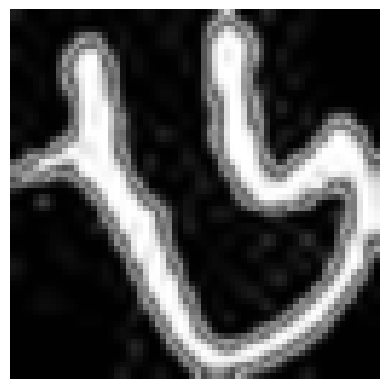

Indices - Grapheme: 133, Vowel: 9, Consonant: 0
Mapping sizes - Grapheme: 47, Vowel: 11, Consonant: 5
⚠️ Grapheme root index 133 out of range (max: 46)
Indices - Grapheme: 133, Vowel: 9, Consonant: 0
Mapping sizes - Grapheme: 47, Vowel: 11, Consonant: 5
⚠️ Grapheme root index 133 out of range (max: 46)
['অো'], ['অো']


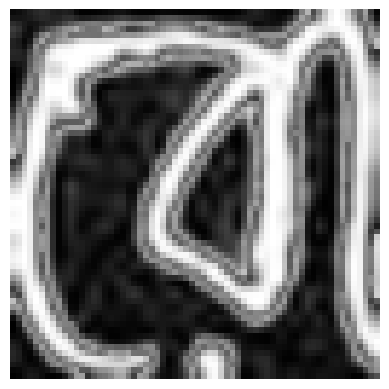

Indices - Grapheme: 67, Vowel: 0, Consonant: 0
Mapping sizes - Grapheme: 47, Vowel: 11, Consonant: 5
⚠️ Grapheme root index 67 out of range (max: 46)
Indices - Grapheme: 67, Vowel: 0, Consonant: 0
Mapping sizes - Grapheme: 47, Vowel: 11, Consonant: 5
⚠️ Grapheme root index 67 out of range (max: 46)
['অ'], ['অ']


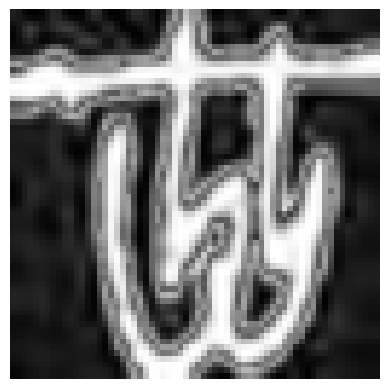

Indices - Grapheme: 1, Vowel: 0, Consonant: 0
Mapping sizes - Grapheme: 47, Vowel: 11, Consonant: 5
Indices - Grapheme: 1, Vowel: 0, Consonant: 0
Mapping sizes - Grapheme: 47, Vowel: 11, Consonant: 5
['আ'], ['আ']


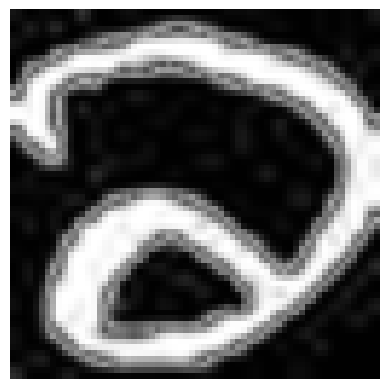

Indices - Grapheme: 54, Vowel: 4, Consonant: 0
Mapping sizes - Grapheme: 47, Vowel: 11, Consonant: 5
⚠️ Grapheme root index 54 out of range (max: 46)
Indices - Grapheme: 54, Vowel: 4, Consonant: 0
Mapping sizes - Grapheme: 47, Vowel: 11, Consonant: 5
⚠️ Grapheme root index 54 out of range (max: 46)
['অু'], ['অু']


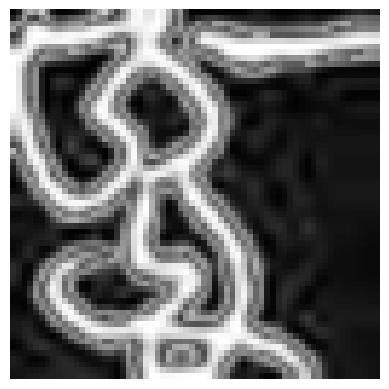

In [43]:
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms

# Randomly select 16 indices from the dataset
random_indices = random.sample(range(len(test_loader.dataset)), 5)

saved_indices = random_indices
transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert tensor to PIL Image
    transforms.Resize((64, 64)),  # Resize the PIL Image
    transforms.ToTensor()  # Convert PIL Image back to tensor
])

# Loop through the randomly selected indices
for i, idx in enumerate(random_indices):
    # Access the dataset associated with the DataLoader
    img = test_loader.dataset[idx]["image"]

    grapheme_root = test_loader.dataset[idx]["grapheme_root"].item()

    vowel_diacritic = test_loader.dataset[idx]["vowel_diacritic"].item()

    consonant_diacritic = test_loader.dataset[idx]["consonant_diacritic"].item()


    input_image = img.unsqueeze(0) 

    input_image = input_image.to(device)


    # Ensure the model is in evaluation mode
    model.eval()

    # Move the model to the GPU (if not already)
    model = model.to(device)

    # Forward pass to get model predictions
    with torch.no_grad():
        outputs = model(input_image)

    # Find the index of the maximum probability for each class
    predicted_grapheme_idx = torch.argmax(outputs[0]).item()
    predicted_vowel_idx = torch.argmax(outputs[1]).item()
    predicted_consonant_idx = torch.argmax(outputs[2]).item()


    correct_char = show_char(grapheme_root,vowel_diacritic,consonant_diacritic)

    #predicted characters:

    pred_char = show_char(predicted_grapheme_idx,predicted_vowel_idx,predicted_consonant_idx)
            
    resized_image = transform(img)        
    img_np = np.transpose(resized_image.numpy(),(1,2,0))
    print(f"{correct_char}, {pred_char}")
    plt.imshow(img_np,cmap='gray')
    plt.axis('off')
    plt.show()
      


(496, 284)
(224, 128)


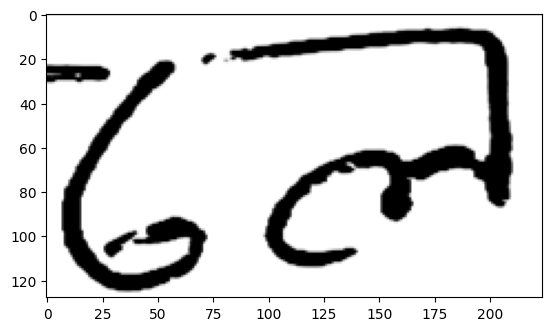

IndexError: list index out of range

In [48]:
from PIL import Image,ImageOps,ImageEnhance
import matplotlib.pyplot as plt
from torchvision import transforms

image_path = 'data/BanglaGrapheme/লে_2.jpg'
img = Image.open(image_path).convert('RGB')
print(img.size)
enhancer = ImageEnhance.Brightness(img)
factor = 10
img_en = enhancer.enhance(factor)
img_inv = ImageOps.invert(img_en)
img_resize = img_inv.resize((224,128))
print(img_resize.size)
plt.imshow(img_resize,cmap='gray')
plt.show() 
transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,)) 
        ])

img_ten = transform(img_resize)

input_image = img_ten.unsqueeze(0) 

input_image = input_image.to(device)

model.eval()

# Move the model to the GPU (if not already)
model = model.to(device)

# Forward pass to get model predictions
with torch.no_grad():
    outputs = model(input_image)

# Find the index of the maximum probability for each class
predicted_grapheme_idx = torch.argmax(outputs[0]).item()
predicted_vowel_idx = torch.argmax(outputs[1]).item()
predicted_consonant_idx = torch.argmax(outputs[2]).item()

predicted_grapheme_root = torch.tensor(predicted_grapheme_idx)
predicted_vowel_diacritic = torch.tensor(predicted_vowel_idx)
predicted_consonant_diacritic = torch.tensor(predicted_consonant_idx)

pred_char = []

if(predicted_vowel_idx != 0 and predicted_consonant_idx != 0):
        if(predicted_consonant_idx == 2):
            pred_char.append( consonant_diacritic_components[predicted_consonant_idx] +  grapheme_root_components[predicted_grapheme_idx] + vowel_diacritic_components[predicted_vowel_idx] )
        elif(predicted_consonant_idx == 1):
            pred_char.append(grapheme_root_components[predicted_grapheme_idx] + vowel_diacritic_components[predicted_vowel_idx] + consonant_diacritic_components[predicted_consonant_idx])
        else:
            pred_char.append(grapheme_root_components[predicted_grapheme_idx] + consonant_diacritic_components[predicted_consonant_idx] + vowel_diacritic_components[predicted_vowel_idx])
   
elif(predicted_vowel_idx == 0 and predicted_consonant_idx == 0):
    pred_char.append(grapheme_root_components[predicted_grapheme_idx])

else:
    if(predicted_vowel_idx == 0):
        if(predicted_consonant_idx == 2):
            pred_char.append( consonant_diacritic_components[predicted_consonant_idx] +  grapheme_root_components[predicted_grapheme_idx] )
        else:
            pred_char.append(grapheme_root_components[predicted_grapheme_idx] + consonant_diacritic_components[predicted_consonant_idx])
    else:
        pred_char.append(grapheme_root_components[predicted_grapheme_idx] + vowel_diacritic_components[predicted_vowel_idx])
        
print(pred_char)  

plt.imshow(img,cmap='gray')
plt.show()        
